In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr
import statsmodels.formula.api as smf

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import echo_utils

# # plot settings
# font = {'family' : 'Bitstream Vera Sans',
#         'weight' : 'regular',
#         'size'   : 13}
# figure = {'figsize' : (16,8)}

# matplotlib.rc('font', **font)
# matplotlib.rc('figure', **figure)


### Single-trial fits (mine)

Ttest_1sampResult(statistic=7.047812909066132, pvalue=8.698888318293546e-06)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     7.648
Date:                Thu, 28 Nov 2019   Prob (F-statistic):            0.00828
Time:                        16:35:13   Log-Likelihood:                 23.924
No. Observations:                  14   AIC:                            -41.85
Df Residuals:                      11   BIC:                            -39.93
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of 

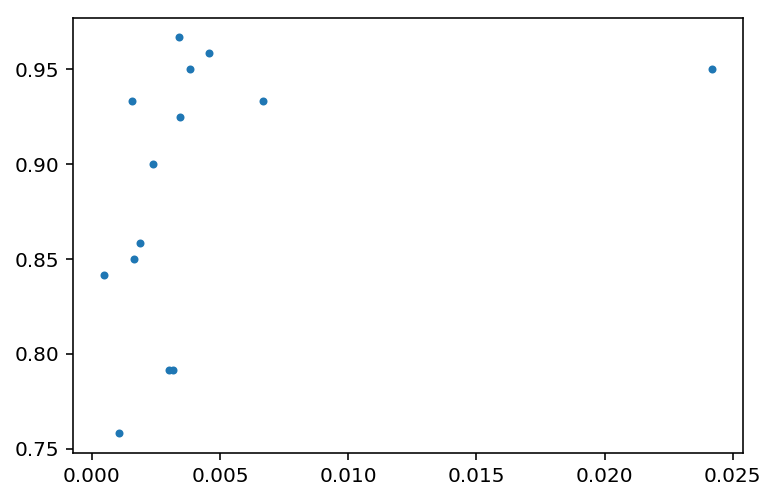

In [189]:
# load metadata
df_patient_info = pd.read_csv('../data/df_johnson_patient_info.csv', index_col=0)
result_path = '../data/johnson/'

# load data
with open(result_path + "all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
with open(result_path + "all_offset.txt", "rb") as fp: # unpickling
    all_offset = pickle.load(fp)
with open(result_path + "all_knee.txt", "rb") as fp: # unpickling
    all_knee = pickle.load(fp)
with open(result_path + "all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)

feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

grand_avg = []

for i_p in range(len(df_patient_info)):
    # remove bad fits if exp<0 or knee<0
    feature[i_p][(all_exp[i_p]<0) | (all_knee[i_p]<=0)] = np.nan
   # feature[i_p][(all_tau[i_p]<0)| (all_tau[i_p]>0.5)] = np.nan
    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    encoding[encoding <= 0] = np.nan
    prestim[prestim <= 0] = np.nan
    encoding[encoding > 0.5] = np.nan
    prestim[prestim > 0.5] = np.nan
    
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    
    # collect results
    grand_avg.append([1-np.isnan(feature[i_p]).sum()/np.prod(feature[i_p].shape), 
                      np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])

df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['data_qual', 'pre', 'enc', 'diff', 'tvals'])

# s3 has really bad data, s15 & s17 are same as s5 & s8
valid_pat = df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,15]].values 
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))
mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())

plt.plot(df_patient['diff'],df_patient['acc'], '.')
#plt.xlim([0, 0.01])
#df_patient

In [182]:
encoding

array([[       nan, 0.23222623,        nan, 0.36230566, 0.02820792,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan, 0.04352309,        nan,
               nan,        nan,        nan, 0.05423144, 0.06337177,
        0.01040951,        nan,        nan,        nan, 0.0214576 ,
        0.06226403,        nan, 0.02471073,        nan,        nan,
               nan,        nan, 0.04507719, 0.09824364, 0.01864828,
               nan, 0.02051754, 0.01408017,        nan,        nan,
        0.00953528,        nan, 0.07026229, 0.03376225,        nan,
        0.01537837, 0.00978614, 0.01180476,        nan,        nan,
               nan, 0.0709179 , 0.01320785,        nan,        nan,
        0.04464552, 0.01211259,        nan, 0.0498436 ,        nan,
        0.03025373, 0.01508287,        nan,        nan,        nan,
               nan, 0.02701524,        nan,        nan,        nan,
               nan, 0.05883467, 0.02496611, 0.03

# Reproducing using Brad's fits

In [183]:
# load data
with open("../notebooks/Johnson/all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
# with open("../notebooks/Johnson/all_offset.txt", "rb") as fp: # unpickling
#     all_offset = pickle.load(fp)
with open("../notebooks/Johnson/all_kfq.txt", "rb") as fp: # unpickling
    all_kfreq = pickle.load(fp)
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)
    
feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

t_vals, p_vals = [], []
grand_avg = []
for i_p in range(len(df_patient_info)-1):    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    encoding[encoding <= 0] = np.nan
    prestim[prestim <= 0] = np.nan
    encoding[encoding > 0.5] = np.nan
    prestim[prestim > 0.5] = np.nan
    
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    grand_avg.append([np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])
    t_vals.append(tval)
    p_vals.append(pv)

#df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['pre', 'enc', 'diff', 'tvals'])
df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], columns=['pre', 'enc', 'diff', 'tvals'])

valid_pat = df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,15]].values # s3 has really bad data, s15 & s17 are same as s5 & s8
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)
df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))

mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())


Ttest_1sampResult(statistic=4.64264145422118, pvalue=0.00046062259763812654)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     9.807
Date:                Thu, 28 Nov 2019   Prob (F-statistic):            0.00359
Time:                        16:34:15   Log-Likelihood:                 24.988
No. Observations:                  14   AIC:                            -43.98
Df Residuals:                      11   BIC:                            -42.06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is n

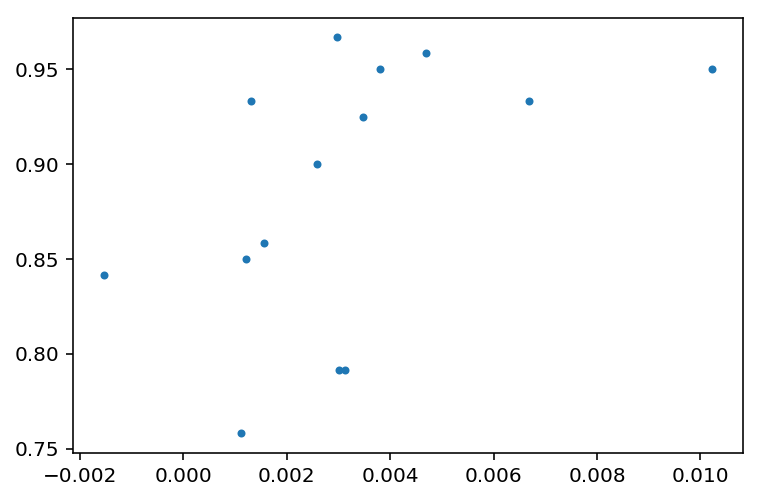

In [185]:
plt.plot(df_patient['diff'],df_patient['acc'], '.')

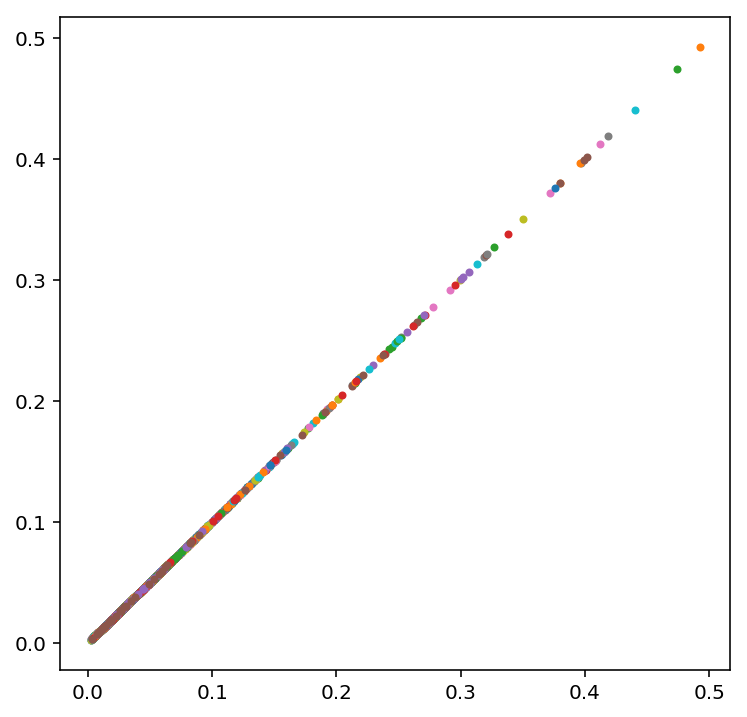

In [188]:
#bv_all_tau = all_tau
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    bv_all_tau = pickle.load(fp)

plt.figure(figsize=(6,6))
cond=0
subj=-8
plt.plot(bv_all_tau[subj][cond], all_tau[subj][cond], '.');
#df_patient.index[-8]

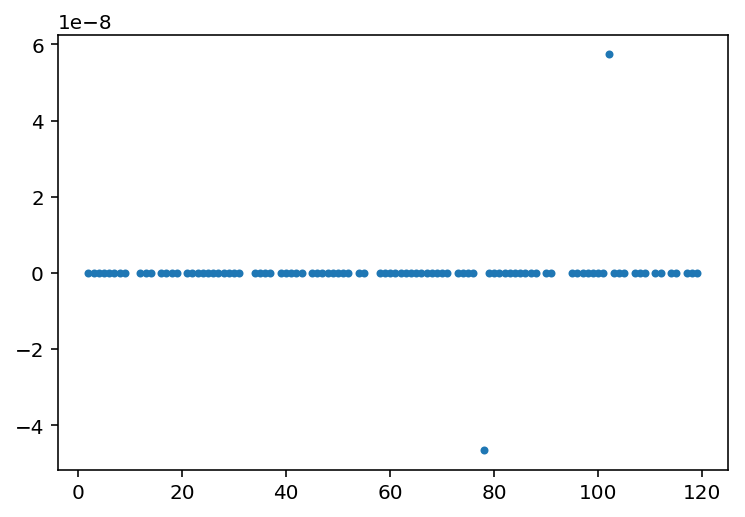

In [92]:
subj, cond, chan = -4, 0, 2
#plt.loglog(bv_all_tau[-2][cond,chan], all_tau[-2][cond,chan], '.')
#plt.plot(plt.xlim(),plt.ylim(), '--')
plt.plot(bv_all_tau[subj][cond,chan]-all_tau[subj][cond,chan], '.')